## 4차 과제 - Hyperparameter Tuning을 해보자
- 주제: 하이퍼파라미터 튜닝 기법 학습
- 데이터: The History of Baseball(Pitching Data) https://www.kaggle.com/datasets/seanlahman/the-history-of-baseball?select=pitching.csv
- 사용 라이브러리: pandas, numpy, matplotlib, sklearn, imblearn, bayes_opt

### 1. EDA, 전처리

1.1 분석을 위해 사용될 라이브러리들을 import 하세요.

numpy, pandas, matplotlib, SMOTE, train_test_split, RandomForestClassifier, RandomizedSearchCV, GridSearchCV, BayesianOptimization, accuracy_score

In [ ]:
!pip install bayesian-optimization

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score


1.2 데이터를 불러오고 info()를 통해 데이터를 살펴보세요.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DAT/pitching.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44139 entries, 0 to 44138
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player_id  44139 non-null  object 
 1   year       44139 non-null  int64  
 2   stint      44139 non-null  int64  
 3   team_id    44139 non-null  object 
 4   league_id  44008 non-null  object 
 5   w          44139 non-null  int64  
 6   l          44139 non-null  int64  
 7   g          44139 non-null  int64  
 8   gs         44139 non-null  int64  
 9   cg         44139 non-null  int64  
 10  sho        44139 non-null  int64  
 11  sv         44139 non-null  int64  
 12  ipouts     44138 non-null  float64
 13  h          44139 non-null  int64  
 14  er         44139 non-null  int64  
 15  hr         44139 non-null  int64  
 16  bb         44139 non-null  int64  
 17  so         44139 non-null  int64  
 18  baopp      42614 non-null  float64
 19  era        44049 non-null  float64
 20  ibb   

1.3 null 값이 있는 컬럼은 모두 삭제하겠습니다(원래는 다른 처리를 해야 하지만 컬럼 수는 충분하니까..ㅎㅎ 야구 잘 몰라서 그런 거 아닙니다.).

In [ ]:
df.dropna(axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44139 entries, 0 to 44138
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   player_id  44139 non-null  object
 1   year       44139 non-null  int64 
 2   stint      44139 non-null  int64 
 3   team_id    44139 non-null  object
 4   w          44139 non-null  int64 
 5   l          44139 non-null  int64 
 6   g          44139 non-null  int64 
 7   gs         44139 non-null  int64 
 8   cg         44139 non-null  int64 
 9   sho        44139 non-null  int64 
 10  sv         44139 non-null  int64 
 11  h          44139 non-null  int64 
 12  er         44139 non-null  int64 
 13  hr         44139 non-null  int64 
 14  bb         44139 non-null  int64 
 15  so         44139 non-null  int64 
 16  bk         44139 non-null  int64 
 17  r          44139 non-null  int64 
dtypes: int64(16), object(2)
memory usage: 6.1+ MB


1.4 연도 별로 몇개의 데이터가 있는 지 확인 후 데이터가 얼마 없는 과거 데이터는 삭제하겠습니다. 이를 위해 연도 별 데이터 수를 계산하고 line plot으로 그리세요.

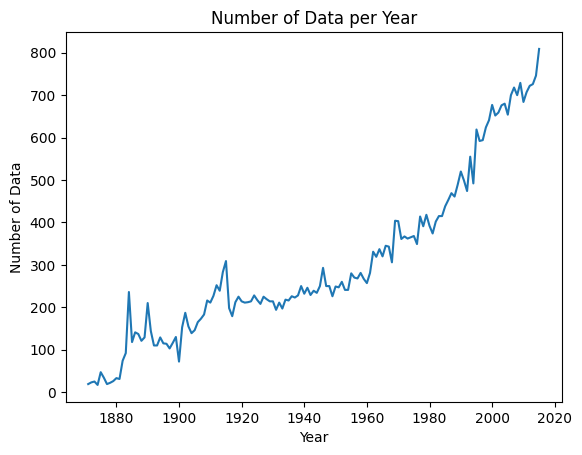

In [ ]:
# 연도 별 데이터 수 계산
year_counts = df['year'].value_counts().sort_index()

# line plot으로 그리기
plt.plot(year_counts.index, year_counts.values)
plt.xlabel('Year')
plt.ylabel('Number of Data')
plt.title('Number of Data per Year')
plt.show()



In [ ]:
year_counts

year
1871     19
1872     23
1873     25
1874     17
1875     47
       ... 
2011    707
2012    722
2013    726
2014    746
2015    809
Name: count, Length: 145, dtype: int64

1.5 보다 최신 분석을 위해 1980년 이후의 데이터만 남기고 몇개의 데이터가 남았는지 확인하세요.

In [ ]:
# 1980년 이후의 데이터만 남기기
df = df[df['year'] >= 1980]

# 남은 데이터 수 확인
print(len(df))
df

21157


,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
22982,aasedo01,1980,1,CAL,8,13,40,21,5,1,2,193,79,13,66,74,1,83
22983,abbotgl01,1980,1,SEA,12,12,31,31,7,2,0,228,98,27,49,78,1,110
22984,alexado01,1980,1,ATL,14,11,35,35,7,1,0,227,108,20,74,114,0,120
22985,allarbr01,1980,1,TEX,0,1,5,2,0,0,0,13,9,0,10,10,0,13
22986,allenne01,1980,1,NYN,7,10,59,0,0,0,22,87,40,7,40,79,1,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44134,youngch03,2015,1,KCA,11,6,34,18,0,0,0,91,42,16,43,83,0,44
44135,zieglbr01,2015,1,ARI,0,3,66,0,0,0,30,48,14,3,17,36,0,17
44136,zimmejo02,2015,1,WAS,13,10,33,33,0,0,0,204,82,24,39,164,1,89
44137,zitoba01,2015,1,OAK,0,0,3,2,0,0,0,12,8,4,6,2,0,8


1.6 reset_index()를 통해 재배열하세요.

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
df

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,aasedo01,1980,1,CAL,8,13,40,21,5,1,2,193,79,13,66,74,1,83
1,abbotgl01,1980,1,SEA,12,12,31,31,7,2,0,228,98,27,49,78,1,110
2,alexado01,1980,1,ATL,14,11,35,35,7,1,0,227,108,20,74,114,0,120
3,allarbr01,1980,1,TEX,0,1,5,2,0,0,0,13,9,0,10,10,0,13
4,allenne01,1980,1,NYN,7,10,59,0,0,0,22,87,40,7,40,79,1,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21152,youngch03,2015,1,KCA,11,6,34,18,0,0,0,91,42,16,43,83,0,44
21153,zieglbr01,2015,1,ARI,0,3,66,0,0,0,30,48,14,3,17,36,0,17
21154,zimmejo02,2015,1,WAS,13,10,33,33,0,0,0,204,82,24,39,164,1,89
21155,zitoba01,2015,1,OAK,0,0,3,2,0,0,0,12,8,4,6,2,0,8


1.7 투수의 승리 수를 예측해보겠습니다. w 컬럼의 value를 확인해보세요.

In [ ]:
df['w'].value_counts()

w
0     5854
1     3197
2     2356
3     1744
4     1453
5     1114
6      878
7      730
9      560
8      557
10     450
11     434
12     384
13     317
14     287
15     242
16     193
17     125
18     102
19      61
20      53
21      32
22      17
24       8
23       7
25       1
27       1
Name: count, dtype: int64

1.8 0승 투수(출전하지 않은 경우도 존재)가 많으므로 승리 수가 0인 데이터는 삭제하겠습니다.

In [ ]:
df = df[df['w'] != 0]

In [ ]:
df

,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,aasedo01,1980,1,CAL,8,13,40,21,5,1,2,193,79,13,66,74,1,83
1,abbotgl01,1980,1,SEA,12,12,31,31,7,2,0,228,98,27,49,78,1,110
2,alexado01,1980,1,ATL,14,11,35,35,7,1,0,227,108,20,74,114,0,120
4,allenne01,1980,1,NYN,7,10,59,0,0,0,22,87,40,7,40,79,1,43
6,andujjo01,1980,1,HOU,3,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,wrighmi01,2015,1,BAL,3,5,12,9,0,0,0,52,30,9,18,26,0,30
21148,wrighst01,2015,1,BOS,5,4,16,9,0,0,0,67,33,12,27,52,0,38
21151,yateski01,2015,1,TBA,1,0,20,0,0,0,0,23,18,10,7,21,0,18
21152,youngch03,2015,1,KCA,11,6,34,18,0,0,0,91,42,16,43,83,0,44


1.9 Regression이 아닌 Classification으로 분석해보겠습니다. 이를 위해 10을 기준으로 w를 10승 이상이면 1, 10승 미만이면 0인 Binary 형태로 변환하세요.

In [ ]:
df['w'] = (df['w'] >= 10).astype(int)
df

<ipython-input-15-cf07b80f397c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['w'] = (df['w'] >= 10).astype(int)


,player_id,year,stint,team_id,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,aasedo01,1980,1,CAL,0,13,40,21,5,1,2,193,79,13,66,74,1,83
1,abbotgl01,1980,1,SEA,1,12,31,31,7,2,0,228,98,27,49,78,1,110
2,alexado01,1980,1,ATL,1,11,35,35,7,1,0,227,108,20,74,114,0,120
4,allenne01,1980,1,NYN,0,10,59,0,0,0,22,87,40,7,40,79,1,43
6,andujjo01,1980,1,HOU,0,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,wrighmi01,2015,1,BAL,0,5,12,9,0,0,0,52,30,9,18,26,0,30
21148,wrighst01,2015,1,BOS,0,4,16,9,0,0,0,67,33,12,27,52,0,38
21151,yateski01,2015,1,TBA,0,0,20,0,0,0,0,23,18,10,7,21,0,18
21152,youngch03,2015,1,KCA,1,6,34,18,0,0,0,91,42,16,43,83,0,44


1.10 value_counts()를 통해 잘 나눠졌는지 확인해보세요.

In [ ]:
df['w'].value_counts()

w
0    12589
1     2714
Name: count, dtype: int64

1.11 종속 변수의 밸런스가 맞지 않는 것으로 확인됩니다. 이를 해결하기 위해 Under Sampling 혹은 Over Sampling 기법을 사용할 수 있는데 Under Sampling의 경우 데이터가 많지 않는 상황에서 사라지는 데이터가 과도하게 많으므로 Over Sampling 기법 중 SMOTE 기법을 사용해보겠습니다. 사용하기 전에 player_id, year, team_id 컬럼은 지우고 가겠습니다.

In [ ]:
df = df.drop(['player_id', 'year', 'team_id'], axis=1)
df

,stint,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r
0,1,0,13,40,21,5,1,2,193,79,13,66,74,1,83
1,1,1,12,31,31,7,2,0,228,98,27,49,78,1,110
2,1,1,11,35,35,7,1,0,227,108,20,74,114,0,120
4,1,0,10,59,0,0,0,22,87,40,7,40,79,1,43
6,1,0,8,35,14,0,0,2,132,53,8,43,75,0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,1,0,5,12,9,0,0,0,52,30,9,18,26,0,30
21148,1,0,4,16,9,0,0,0,67,33,12,27,52,0,38
21151,1,0,0,20,0,0,0,0,23,18,10,7,21,0,18
21152,1,1,6,34,18,0,0,0,91,42,16,43,83,0,44


1.12 SMOTE 기법을 활용해 w의 balance를 맞추세요(sampling_strategy='auto', random_state = 123).

In [ ]:

smote = SMOTE(sampling_strategy='auto', random_state=123)
X_resampled, y_resampled = smote.fit_resample(df.drop('w', axis=1), df['w'])


In [ ]:
df_resampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)

In [ ]:
df_resampled.columns

Index(['stint', 'l', 'g', 'gs', 'cg', 'sho', 'sv', 'h', 'er', 'hr', 'bb', 'so',
       'bk', 'r', 'w'],
      dtype='object')

In [ ]:
df_resampled=df_resampled[['w', 'l', 'g', 'gs', 'cg', 'sho', 'sv', 'h', 'er', 'hr', 'bb', 'so', 'bk', 'r', 'stint']]

1.13 balance가 잘 맞춰졌는지 확인하세요.

In [ ]:
print(df_resampled['w'].value_counts())
df_resampled

w
0    12589
1    12589
Name: count, dtype: int64


,w,l,g,gs,cg,sho,sv,h,er,hr,bb,so,bk,r,stint
0,0,13,40,21,5,1,2,193,79,13,66,74,1,83,1
1,1,12,31,31,7,2,0,228,98,27,49,78,1,110,1
2,1,11,35,35,7,1,0,227,108,20,74,114,0,120,1
3,0,10,59,0,0,0,22,87,40,7,40,79,1,43,1
4,0,8,35,14,0,0,2,132,53,8,43,75,0,59,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25173,1,14,34,34,3,0,0,267,131,24,86,139,0,142,1
25174,1,7,32,32,1,0,0,210,88,21,69,105,0,100,1
25175,1,7,29,29,4,1,0,172,68,16,52,129,1,72,1
25176,1,5,71,0,0,0,6,90,35,6,43,97,2,43,1


1.14 SMOTE의 동작 방식에 대해 작성하고 Over Sampling의 장/단점에 대해 작성하세요.

###SMOTE(Synthetic Minority Over-sampling Technique)

####SMOTE는 불균형 데이터셋을 다루기 위한 대표적인 오버샘플링 기법입니다. 이는 소수 클래스의 샘플을 합성하여 데이터셋의 클래스 분포를 균형 잡습니다.

SMOTE 알고리즘은 다음과 같습니다.

1. 소수 클래스의 샘플을 선택합니다.
2. 선택된 샘플의 k개의 최근접 이웃을 찾습니다.
3. 선택된 샘플과 그 이웃 사이의 선분을 무작위로 선택합니다.
4. 선분 위의 임의의 지점을 선택하여 새로운 샘플을 생성합니다.
5. 생성된 샘플을 데이터셋에 추가합니다.

**오버샘플링의 장점:**
- 불균형 데이터셋의 클래스 분포를 균형 잡을 수 있습니다.
-소수 클래스의 패턴을 더 잘 학습할 수 있습니다.
-소수 클래스의 예측 성능을 향상시킬 수 있습니다.

**오버샘플링의 단점:**
- 과적합될 수 있습니다.
-합성된 샘플이 실제 데이터와 다를 수 있습니다.
-데이터셋의 크기가 증가할 수 있습니다.

전반적으로 SMOTE는 불균형 데이터셋을 다루기 위한 효과적인 기법입니다. 그러나 과적합될 수 있으므로 주의해서 사용해야 합니다.

1.15 다른 Over Sampling 기법들엔 어떤 것들이 있는지 작성하세요(2개 이상).

- **랜덤 오버샘플링(Random Oversampling)**: 소수 클래스의 샘플을 무작위로 복제하여 데이터셋에 추가합니다. 이는 가장 간단한 오버샘플링 기법이지만 과적합될 수 있습니다.
-**ADASYN(Adaptive Synthetic Sampling)**: SMOTE와 유사하지만 소수 클래스의 샘플이 어려운 샘플일수록 더 많은 샘플을 생성합니다. 이는 과적합을 줄이는 데 도움이 될 수 있습니다.
-**Borderline-SMOTE**: SMOTE와 유사하지만 데이터셋의 경계에 있는 소수 클래스의 샘플에 더 많은 가중치를 둡니다. 이는 소수 클래스의 예측 성능을 향상시키는 데 도움이 될 수 있습니다.
-**K-Means SMOTE**: SMOTE와 유사하지만 소수 클래스의 샘플을 K-Means 클러스터링을 사용하여 그룹화한 다음 각 클러스터 내에서 새로운 샘플을 생성합니다. 이는 소수 클래스의 패턴을 더 잘 학습하는 데 도움이 될 수 있습니다.

### 2. 예측 및 분석

2.1 본격적으로 분석을 진행하겠습니다. 본 차시는 Hyperparameter Tuning에 대해 학습하는 것이 목적이므로 모델은 RandomForest Classifier 하나만 사용하도록 하겠습니다. 먼저 데이터를 train, validation, test 3개로 나누세요(trian-60%, val-20%, test-20%).

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(df_resampled.drop('w', axis=1), df_resampled['w'], test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=123)


In [ ]:
print(f"Train set size: {len(X_train)} \nValidation set size: {len(X_val)} \nTest set size: {len(X_test)}")

Train set size: 15106 
Validation set size: 5036 
Test set size: 5036


2.2 train test에 validation set을 추가하는 이유가 뭔지 작성하세요.

- **모델 튜닝**: 검증 세트를 사용하면 모델의 하이퍼파라미터를 조정할 수 있습니다. 하이퍼파라미터는 모델이 학습하는 데 사용되는 설정입니다(예: 의사결정나무의 최대 깊이 또는 신경망의 학습률). 검증 세트에서 모델의 성능을 모니터링하여 최적의 하이퍼파라미터 조합을 찾을 수 있습니다.
-**과적합 감지**: 검증 세트를 사용하면 모델의 과적합을 감지할 수 있습니다. 과적합은 모델이 훈련 데이터에 너무 잘 맞아 테스트 데이터에 대해 일반화되지 않는 경우입니다. 검증 세트에서 모델의 성능이 훈련 세트에서의 성능보다 현저히 낮으면 모델이 과적합되었을 가능성이 높습니다.
-**모델 선택**: 검증 세트를 사용하면 여러 모델 중에서 최상의 모델을 선택할 수 있습니다. 각 모델을 검증 세트에서 훈련시키고 평가하여 가장 높은 성능을 보이는 모델을 선택할 수 있습니다.
검증 세트는 일반적으로 훈련 세트의 일부를 분할하여 생성합니다.

검증 세트의 크기는 데이터셋의 크기에 따라 다르지만 일반적으로 훈련 세트의 10~20% 정도가 적절합니다.

2.3 Randomized SearchCV로 최적의 파라미터 셋을 찾으세요(성능 지표는 accuracy score).

In [ ]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [ ]:
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, n_iter=30, cv=3, scoring='accuracy', random_state=123)
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=30,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200]},
                   random_state=123, scoring='accuracy')

In [ ]:
print(random_search.best_params_)


{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}


2.4 위에서 지정한 hyperparameter들이 각각 무엇을 의미하는지 작성하세요.

**n_estimators**: 의사결정나무의 개수를 나타냅니다. 의사결정나무의 개수가 많을수록 모델이 더 복잡해지고 과적합될 가능성이 높아집니다.

**max_depth**: 각 의사결정나무의 최대 깊이를 나타냅니다. 의사결정나무의 깊이가 클수록 모델이 더 복잡해지고 과적합될 가능성이 높아집니다.

**min_samples_split**: 노드를 분할하기 위한 최소 샘플 수를 나타냅니다. 이 값이 클수록 모델이 더 단순해지고 과적합될 가능성이 낮아집니다.

**min_samples_leaf**: 리프 노드에 있어야 하는 최소 샘플 수를 나타냅니다. 이 값이 클수록 모델이 더 단순해지고 과적합될 가능성이 낮아집니다.

**bootstrap**: 부트스트랩 샘플링을 사용할지 여부를 나타냅니다. 부트스트랩 샘플링을 사용하면 모델이 더 강력해지고 과적합될 가능성이 낮아집니다.

**criterion**: 노드를 분할하는 데 사용할 기준을 나타냅니다. '지니 불순도'와 '엔트로피'가 일반적으로 사용됩니다.

이러한 하이퍼파라미터는 모두 의사결정나무 모델의 성능에 영향을 미칩니다. 최적의 하이퍼파라미터 조합을 찾기 위해서는 교차 검증을 사용하여 모델을 평가해야 합니다.

2.5 Grid SearchCV로 최적의 파라미터 셋을 찾으세요.

In [ ]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [ ]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)


{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


2.6 Randomized SearchCV와 Grid SearchCV의 차이와 장단점에 대해 설명하세요.

<figure>
    <img src="https://miro.medium.com/v2/resize:fit:781/1*8uSZqUSGa-UGF-0CDBd4Jw.png">
</figure>

**Randomized SearchCV:**

- 장점:
    - Grid SearchCV보다 계산 비용이 적습니다.
    - 하이퍼파라미터 공간을 더 광범위하게 탐색할 수 있습니다.
- 단점:
    -최적의 하이퍼파라미터 조합을 찾을 가능성이 낮습니다.
    -반복 실행 결과가 다를 수 있습니다.

**Grid SearchCV:**

- 장점:
    - 최적의 하이퍼파라미터 조합을 찾을 가능성이 높습니다.
    - 반복 실행 결과가 일관적입니다.
- 단점:
    - Randomized SearchCV보다 계산 비용이 많이 듭니다.
    - 하이퍼파라미터 공간을 광범위하게 탐색할 수 없습니다.

**차이점:**

- Randomized SearchCV는 하이퍼파라미터 공간을 무작위로 샘플링하여 탐색하는 반면, Grid SearchCV는 하이퍼파라미터 공간을 체계적으로 탐색합니다.
- Randomized SearchCV는 계산 비용이 적고 하이퍼파라미터 공간을 더 광범위하게 탐색할 수 있지만 최적의 하이퍼파라미터 조합을 찾을 가능성이 낮습니다.
- Grid SearchCV는 계산 비용이 많이 들고 하이퍼파라미터 공간을 광범위하게 탐색할 수 없지만 최적의 하이퍼파라미터 조합을 찾을 가능성이 높습니다.

**선택 기준:**

- 계산 비용이 중요하지 않고 최적의 하이퍼파라미터 조합을 찾는 것이 중요하다면 Grid SearchCV를 사용하는 것이 좋습니다.
-계산 비용이 중요하고 하이퍼파라미터 공간을 광범위하게 탐색하는 것이 중요하다면 Randomized SearchCV를 사용하는 것이 좋습니다.

2.7 이번엔 Bayesian Optimization을 사용해 파라미터 튜닝을 진행해보겠습니다.

In [ ]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [ ]:
def rf_crossval(n_estimators, max_depth, min_samples_split, min_samples_leaf, bootstrap, criterion):
    # Convert categorical parameters to appropriate format
    bootstrap = True if bootstrap > 0.5 else False
    criterion = 'gini' if criterion < 0.5 else 'entropy'

    rf = RandomForestClassifier(n_estimators=int(n_estimators),
                               max_depth=int(max_depth),
                               min_samples_split=int(min_samples_split),
                               min_samples_leaf=int(min_samples_leaf),
                               bootstrap=bootstrap,
                               criterion=criterion,
                               random_state=123,
                               n_jobs=-1)
    scores = cross_val_score(rf, X_train, y_train, cv=3, scoring='accuracy')
    return scores.mean()


optimizer = BayesianOptimization(
    f=rf_crossval,
    pbounds={
        'n_estimators': (10, 200),
        'max_depth': (10, 30),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 4),
        'bootstrap': (0, 1),
        'criterion': (0, 1)
    },
    random_state=123
)

optimizer.maximize(init_points=5, n_iter=10)

print("Best Parameters:", optimizer.max['params'])

|   iter    |  target   | bootstrap | criterion | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | 0.9454    | 0.6965    | 0.2861    | 14.54     | 2.654     | 7.756     | 90.39     |
| 2         | 0.9479    | 0.9808    | 0.6848    | 19.62     | 2.176     | 4.745     | 148.5     |
| 3         | 0.9496    | 0.4386    | 0.05968   | 17.96     | 3.214     | 3.46      | 43.34     |
| 4         | 0.9451    | 0.5316    | 0.5318    | 22.69     | 3.548     | 7.796     | 126.1     |
| 5         | 0.9487    | 0.7224    | 0.323     | 17.24     | 1.685     | 4.35      | 129.9     |
| 6         | 0.9402    | 0.7217    | 0.8784    | 10.07     | 3.793     | 8.678     | 182.4     |
| 7         | 0.9397    | 0.736     | 0.4166    | 10.14     | 3.921     | 7.806     | 132.7     |
| 8         | 0.946     | 0.6637    | 0.6959    | 19.07     | 3.912     | 6.641     | 25.73     |
| 9         | 0.9492

2.8 진행한 튜닝 과정에서 찾은 최적의 파라미터 셋으로 다시 학습을 진행한 후 최종 accuracy score을 출력하세요.

In [ ]:

# Randomized SearchCV
random_search_model = RandomForestClassifier(**random_search.best_params_)
random_search_model.fit(X_train, y_train)
random_search_score = accuracy_score(y_test, random_search_model.predict(X_test))
print('Randomized SearchCV Accuracy:', random_search_score)


Randomized SearchCV Accuracy: 0.9588959491660047


In [ ]:

# Grid SearchCV
grid_search_model = RandomForestClassifier(**grid_search.best_params_)
grid_search_model.fit(X_train, y_train)
grid_search_score = accuracy_score(y_test, grid_search_model.predict(X_test))
print('Grid SearchCV Accuracy:', grid_search_score)


Grid SearchCV Accuracy: 0.9608816521048451


In [ ]:
#bootstrap_value = True if optimizer.max['params']['bootstrap'] > 0.5 else False
#optimizer.max['params']['bootstrap'] = bootstrap_value

bayesian_model = RandomForestClassifier(**optimizer.max['params'])
bayesian_model.fit(X_train, y_train)
bayesian_score = accuracy_score(y_test, bayesian_model.predict(X_test))
print('Bayesian Optimization Accuracy:', bayesian_score)

InvalidParameterError: The 'bootstrap' parameter of RandomForestClassifier must be an instance of 'bool', an instance of 'numpy.bool_' or an instance of 'int'. Got 0.22304657977398368 instead.

### 3. 자유분석

최적의 파라미터 셋을 찾고 성능을 높여보세요.

In [ ]:
#random_search cv를 5로
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, n_iter=30, cv=5, scoring='accuracy', random_state=123)
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=30,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200]},
                   random_state=123, scoring='accuracy')

In [ ]:
print(random_search.best_params_)


{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}


In [ ]:

# Randomized SearchCV
random_search_model = RandomForestClassifier(**random_search.best_params_)
random_search_model.fit(X_train, y_train)
random_search_score = accuracy_score(y_test, random_search_model.predict(X_test))
print('Randomized SearchCV Accuracy:', random_search_score)


Randomized SearchCV Accuracy: 0.9583002382843526


In [ ]:
# prompt: 변수 중요도를 알려줘

import numpy as np
# Get feature importances
importances = random_search_model.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for i in sorted_indices:
    print(f"{df_resampled.columns[i]:<15} {importances[i]:.4f}")


Feature ranking:
g               0.2266
bb              0.1758
h               0.1402
sv              0.1217
bk              0.0920
hr              0.0898
w               0.0433
er              0.0315
l               0.0314
gs              0.0239
sho             0.0100
so              0.0084
cg              0.0049
r               0.0004


In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.1 MB/s eta 0:00:00


In [ ]:

# Optuna를 사용하여 최적의 파라미터 셋을 찾습니다.
import optuna

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        criterion=criterion,
        random_state=123,
        n_jobs=-1
    )

    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# 최적의 파라미터 셋을 사용하여 모델을 학습합니다.
best_params = study.best_params
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)

# 최종 accuracy score를 출력합니다.
best_score = accuracy_score(y_test, best_model.predict(X_test))
print('Optuna Accuracy:', best_score)


[I 2024-04-09 14:54:51,379] A new study created in memory with name: no-name-fedb7c07-2df4-4a5e-985f-474fc1e1a3e5
[I 2024-04-09 14:54:56,930] Trial 0 finished with value: 0.9430688384906397 and parameters: {'n_estimators': 153, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'bootstrap': True, 'criterion': 'gini'}. Best is trial 0 with value: 0.9430688384906397.
[I 2024-04-09 14:55:07,533] Trial 1 finished with value: 0.9451872897133358 and parameters: {'n_estimators': 135, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True, 'criterion': 'gini'}. Best is trial 1 with value: 0.9451872897133358.
[I 2024-04-09 14:55:23,137] Trial 2 finished with value: 0.9523368062429817 and parameters: {'n_estimators': 181, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 2 with value: 0.9523368062429817.
[I 2024-04-09 14:55:30,435] Trial 3 finished with value: 0.9472394851080824 and para

Optuna Accuracy: 0.9588959491660047


야구 특성을 고려한 전처리  
null값이 포함된 column이 승리에 영향을 주는 것이 많아보여서  
차라리 null값인 row를 삭제

In [ ]:
df1=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DAT/pitching.csv")

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44139 entries, 0 to 44138
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player_id  44139 non-null  object 
 1   year       44139 non-null  int64  
 2   stint      44139 non-null  int64  
 3   team_id    44139 non-null  object 
 4   league_id  44008 non-null  object 
 5   w          44139 non-null  int64  
 6   l          44139 non-null  int64  
 7   g          44139 non-null  int64  
 8   gs         44139 non-null  int64  
 9   cg         44139 non-null  int64  
 10  sho        44139 non-null  int64  
 11  sv         44139 non-null  int64  
 12  ipouts     44138 non-null  float64
 13  h          44139 non-null  int64  
 14  er         44139 non-null  int64  
 15  hr         44139 non-null  int64  
 16  bb         44139 non-null  int64  
 17  so         44139 non-null  int64  
 18  baopp      42614 non-null  float64
 19  era        44049 non-null  float64
 20  ibb   

In [ ]:
# 1980년 이후의 데이터만 남기기
df1 = df1[df1['year'] >= 1980]

# 남은 데이터 수 확인
print(len(df1))
df1

21157


,player_id,year,stint,team_id,league_id,w,l,g,gs,cg,...,ibb,wp,hbp,bk,bfp,gf,r,sh,sf,g_idp
22982,aasedo01,1980,1,CAL,AL,8,13,40,21,5,...,3.0,2.0,1.0,1,761.0,6.0,83,NaN,NaN,NaN
22983,abbotgl01,1980,1,SEA,AL,12,12,31,31,7,...,4.0,1.0,3.0,1,903.0,0.0,110,NaN,NaN,NaN
22984,alexado01,1980,1,ATL,NL,14,11,35,35,7,...,5.0,3.0,4.0,0,981.0,0.0,120,NaN,NaN,NaN
22985,allarbr01,1980,1,TEX,AL,0,1,5,2,0,...,1.0,1.0,1.0,0,67.0,2.0,13,NaN,NaN,NaN
22986,allenne01,1980,1,NYN,NL,7,10,59,0,0,...,9.0,2.0,0.0,1,407.0,47.0,43,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44134,youngch03,2015,1,KCA,AL,11,6,34,18,0,...,0.0,5.0,0.0,0,500.0,3.0,44,4.0,2.0,NaN
44135,zieglbr01,2015,1,ARI,NL,0,3,66,0,0,...,3.0,2.0,1.0,0,263.0,46.0,17,1.0,0.0,NaN
44136,zimmejo02,2015,1,WAS,NL,13,10,33,33,0,...,3.0,2.0,8.0,1,831.0,0.0,89,8.0,2.0,NaN
44137,zitoba01,2015,1,OAK,AL,0,0,3,2,0,...,0.0,0.0,0.0,0,37.0,1.0,8,0.0,0.0,NaN


In [ ]:
df1

,player_id,year,stint,team_id,league_id,w,l,g,gs,cg,...,ibb,wp,hbp,bk,bfp,gf,r,sh,sf,g_idp
22982,aasedo01,1980,1,CAL,AL,8,13,40,21,5,...,3.0,2.0,1.0,1,761.0,6.0,83,NaN,NaN,NaN
22983,abbotgl01,1980,1,SEA,AL,12,12,31,31,7,...,4.0,1.0,3.0,1,903.0,0.0,110,NaN,NaN,NaN
22984,alexado01,1980,1,ATL,NL,14,11,35,35,7,...,5.0,3.0,4.0,0,981.0,0.0,120,NaN,NaN,NaN
22985,allarbr01,1980,1,TEX,AL,0,1,5,2,0,...,1.0,1.0,1.0,0,67.0,2.0,13,NaN,NaN,NaN
22986,allenne01,1980,1,NYN,NL,7,10,59,0,0,...,9.0,2.0,0.0,1,407.0,47.0,43,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44134,youngch03,2015,1,KCA,AL,11,6,34,18,0,...,0.0,5.0,0.0,0,500.0,3.0,44,4.0,2.0,NaN
44135,zieglbr01,2015,1,ARI,NL,0,3,66,0,0,...,3.0,2.0,1.0,0,263.0,46.0,17,1.0,0.0,NaN
44136,zimmejo02,2015,1,WAS,NL,13,10,33,33,0,...,3.0,2.0,8.0,1,831.0,0.0,89,8.0,2.0,NaN
44137,zitoba01,2015,1,OAK,AL,0,0,3,2,0,...,0.0,0.0,0.0,0,37.0,1.0,8,0.0,0.0,NaN


In [ ]:
df1 = df1[df1['w'] != 0]

In [ ]:
df1

,player_id,year,stint,team_id,league_id,w,l,g,gs,cg,...,ibb,wp,hbp,bk,bfp,gf,r,sh,sf,g_idp
22982,aasedo01,1980,1,CAL,AL,8,13,40,21,5,...,3.0,2.0,1.0,1,761.0,6.0,83,NaN,NaN,NaN
22983,abbotgl01,1980,1,SEA,AL,12,12,31,31,7,...,4.0,1.0,3.0,1,903.0,0.0,110,NaN,NaN,NaN
22984,alexado01,1980,1,ATL,NL,14,11,35,35,7,...,5.0,3.0,4.0,0,981.0,0.0,120,NaN,NaN,NaN
22986,allenne01,1980,1,NYN,NL,7,10,59,0,0,...,9.0,2.0,0.0,1,407.0,47.0,43,NaN,NaN,NaN
22988,andujjo01,1980,1,HOU,NL,3,8,35,14,0,...,2.0,2.0,0.0,0,529.0,5.0,59,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44129,wrighmi01,2015,1,BAL,AL,3,5,12,9,0,...,3.0,2.0,5.0,0,204.0,0.0,30,0.0,2.0,NaN
44130,wrighst01,2015,1,BOS,AL,5,4,16,9,0,...,0.0,2.0,1.0,0,310.0,3.0,38,1.0,1.0,NaN
44133,yateski01,2015,1,TBA,AL,1,0,20,0,0,...,0.0,0.0,1.0,0,92.0,10.0,18,0.0,0.0,NaN
44134,youngch03,2015,1,KCA,AL,11,6,34,18,0,...,0.0,5.0,0.0,0,500.0,3.0,44,4.0,2.0,NaN


In [ ]:
df1 = df1.drop(['player_id', 'year', 'team_id'], axis=1)
df1

,stint,league_id,w,l,g,gs,cg,sho,sv,ipouts,...,ibb,wp,hbp,bk,bfp,gf,r,sh,sf,g_idp
22982,1,AL,8,13,40,21,5,1,2,525.0,...,3.0,2.0,1.0,1,761.0,6.0,83,NaN,NaN,NaN
22983,1,AL,12,12,31,31,7,2,0,645.0,...,4.0,1.0,3.0,1,903.0,0.0,110,NaN,NaN,NaN
22984,1,NL,14,11,35,35,7,1,0,695.0,...,5.0,3.0,4.0,0,981.0,0.0,120,NaN,NaN,NaN
22986,1,NL,7,10,59,0,0,0,22,292.0,...,9.0,2.0,0.0,1,407.0,47.0,43,NaN,NaN,NaN
22988,1,NL,3,8,35,14,0,0,2,366.0,...,2.0,2.0,0.0,0,529.0,5.0,59,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44129,1,AL,3,5,12,9,0,0,0,134.0,...,3.0,2.0,5.0,0,204.0,0.0,30,0.0,2.0,NaN
44130,1,AL,5,4,16,9,0,0,0,218.0,...,0.0,2.0,1.0,0,310.0,3.0,38,1.0,1.0,NaN
44133,1,AL,1,0,20,0,0,0,0,61.0,...,0.0,0.0,1.0,0,92.0,10.0,18,0.0,0.0,NaN
44134,1,AL,11,6,34,18,0,0,0,370.0,...,0.0,5.0,0.0,0,500.0,3.0,44,4.0,2.0,NaN


In [ ]:
df1 = df1.drop(['stint'], axis=1)

In [ ]:
# ibb가 null인 row를 삭제

df1 = df1[df1['ibb'].notnull()]


In [ ]:
# baopp와  era가 null인 row를 삭제

df1 = df1.dropna(subset=['baopp', 'era'])


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14849 entries, 22982 to 44136
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   league_id  14849 non-null  object 
 1   w          14849 non-null  int64  
 2   l          14849 non-null  int64  
 3   g          14849 non-null  int64  
 4   gs         14849 non-null  int64  
 5   cg         14849 non-null  int64  
 6   sho        14849 non-null  int64  
 7   sv         14849 non-null  int64  
 8   ipouts     14849 non-null  float64
 9   h          14849 non-null  int64  
 10  er         14849 non-null  int64  
 11  hr         14849 non-null  int64  
 12  bb         14849 non-null  int64  
 13  so         14849 non-null  int64  
 14  baopp      14849 non-null  float64
 15  era        14849 non-null  float64
 16  ibb        14849 non-null  float64
 17  wp         14849 non-null  float64
 18  hbp        14849 non-null  float64
 19  bk         14849 non-null  int64  
 20  bfp    

In [ ]:
# sh와 sf가 null인 row를 삭제
df1 = df1.dropna(subset=['sh', 'sf'])


In [ ]:
# g_idp 열을 삭제, 너무 유효값이 적어서

df1 = df1.drop(['g_idp'], axis=1)


In [ ]:
df2=df1

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7878 entries, 32900 to 44136
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   league_id  7878 non-null   object 
 1   w          7878 non-null   int64  
 2   l          7878 non-null   int64  
 3   g          7878 non-null   int64  
 4   gs         7878 non-null   int64  
 5   cg         7878 non-null   int64  
 6   sho        7878 non-null   int64  
 7   sv         7878 non-null   int64  
 8   ipouts     7878 non-null   float64
 9   h          7878 non-null   int64  
 10  er         7878 non-null   int64  
 11  hr         7878 non-null   int64  
 12  bb         7878 non-null   int64  
 13  so         7878 non-null   int64  
 14  baopp      7878 non-null   float64
 15  era        7878 non-null   float64
 16  ibb        7878 non-null   float64
 17  wp         7878 non-null   float64
 18  hbp        7878 non-null   float64
 19  bk         7878 non-null   int64  
 20  bfp     

In [ ]:
df2 = df2.reset_index(drop=True)
df2

,league_id,w,l,g,gs,cg,sho,sv,ipouts,h,...,era,ibb,wp,hbp,bk,bfp,gf,r,sh,sf
0,AL,9,7,35,27,0,0,0,537.0,164,...,4.22,4.0,3.0,5.0,0,766.0,2.0,89,1.0,4.0
1,NL,3,7,62,0,0,0,0,248.0,77,...,3.81,9.0,3.0,1.0,2,347.0,18.0,38,1.0,1.0
2,NL,6,9,66,0,0,0,2,253.0,80,...,3.52,0.0,5.0,0.0,0,369.0,18.0,42,3.0,0.0
3,NL,1,2,54,0,0,0,29,143.0,47,...,4.91,2.0,1.0,4.0,0,210.0,44.0,28,1.0,0.0
4,NL,1,3,23,0,0,0,0,61.0,23,...,5.75,0.0,1.0,1.0,0,95.0,5.0,14,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7873,AL,3,5,12,9,0,0,0,134.0,52,...,6.04,3.0,2.0,5.0,0,204.0,0.0,30,0.0,2.0
7874,AL,5,4,16,9,0,0,0,218.0,67,...,4.09,0.0,2.0,1.0,0,310.0,3.0,38,1.0,1.0
7875,AL,1,0,20,0,0,0,0,61.0,23,...,7.97,0.0,0.0,1.0,0,92.0,10.0,18,0.0,0.0
7876,AL,11,6,34,18,0,0,0,370.0,91,...,3.06,0.0,5.0,0.0,0,500.0,3.0,44,4.0,2.0


In [ ]:
df2['w'] = (df2['w'] >= 10).astype(int)
df2

,league_id,w,l,g,gs,cg,sho,sv,ipouts,h,...,era,ibb,wp,hbp,bk,bfp,gf,r,sh,sf
0,AL,0,7,35,27,0,0,0,537.0,164,...,4.22,4.0,3.0,5.0,0,766.0,2.0,89,1.0,4.0
1,NL,0,7,62,0,0,0,0,248.0,77,...,3.81,9.0,3.0,1.0,2,347.0,18.0,38,1.0,1.0
2,NL,0,9,66,0,0,0,2,253.0,80,...,3.52,0.0,5.0,0.0,0,369.0,18.0,42,3.0,0.0
3,NL,0,2,54,0,0,0,29,143.0,47,...,4.91,2.0,1.0,4.0,0,210.0,44.0,28,1.0,0.0
4,NL,0,3,23,0,0,0,0,61.0,23,...,5.75,0.0,1.0,1.0,0,95.0,5.0,14,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7873,AL,0,5,12,9,0,0,0,134.0,52,...,6.04,3.0,2.0,5.0,0,204.0,0.0,30,0.0,2.0
7874,AL,0,4,16,9,0,0,0,218.0,67,...,4.09,0.0,2.0,1.0,0,310.0,3.0,38,1.0,1.0
7875,AL,0,0,20,0,0,0,0,61.0,23,...,7.97,0.0,0.0,1.0,0,92.0,10.0,18,0.0,0.0
7876,AL,1,6,34,18,0,0,0,370.0,91,...,3.06,0.0,5.0,0.0,0,500.0,3.0,44,4.0,2.0


In [ ]:
# league_id를 제거

df2 = df2.drop(['league_id'], axis=1)


똑같이 진행

1.12 SMOTE 기법을 활용해 w의 balance를 맞추세요(sampling_strategy='auto', random_state = 123).

In [ ]:

smote = SMOTE(sampling_strategy='auto', random_state=123)
X_resampled, y_resampled = smote.fit_resample(df2.drop('w', axis=1), df2['w'])


In [ ]:
df2_resampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)

In [ ]:
df2_resampled.columns

Index(['l', 'g', 'gs', 'cg', 'sho', 'sv', 'ipouts', 'h', 'er', 'hr', 'bb',
       'so', 'baopp', 'era', 'ibb', 'wp', 'hbp', 'bk', 'bfp', 'gf', 'r', 'sh',
       'sf', 'w'],
      dtype='object')

1.13 balance가 잘 맞춰졌는지 확인하세요.

In [ ]:
print(df2_resampled['w'].value_counts())
df2_resampled

w
0    6623
1    6623
Name: count, dtype: int64


,l,g,gs,cg,sho,sv,ipouts,h,er,hr,...,ibb,wp,hbp,bk,bfp,gf,r,sh,sf,w
0,7,35,27,0,0,0,537.000000,164,84,23,...,4.000000,3.000000,5.000000,0,766.000000,2.0,89,1.000000,4.000000,0
1,7,62,0,0,0,0,248.000000,77,35,11,...,9.000000,3.000000,1.000000,2,347.000000,18.0,38,1.000000,1.000000,0
2,9,66,0,0,0,2,253.000000,80,33,6,...,0.000000,5.000000,0.000000,0,369.000000,18.0,42,3.000000,0.000000,0
3,2,54,0,0,0,29,143.000000,47,26,11,...,2.000000,1.000000,4.000000,0,210.000000,44.0,28,1.000000,0.000000,0
4,3,23,0,0,0,0,61.000000,23,13,3,...,0.000000,1.000000,1.000000,0,95.000000,5.0,14,1.000000,2.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13241,12,30,30,1,0,0,578.265536,165,66,11,...,2.623890,12.000000,9.000000,0,804.761097,0.0,77,8.752219,3.376110,1
13242,7,21,21,1,0,0,411.809937,137,55,14,...,0.114038,3.114038,0.304101,1,572.190063,0.0,60,2.076025,3.000000,1
13243,11,31,31,0,0,0,587.734119,180,73,15,...,9.202358,10.417649,4.683530,0,808.101179,0.0,82,6.784709,5.417649,1
13244,9,32,32,1,0,0,631.002650,213,82,19,...,2.251657,1.000000,5.250331,0,858.254307,0.0,88,3.750994,7.500663,1


In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(df2_resampled.drop('w', axis=1), df2_resampled['w'], test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=123)


2.3 Randomized SearchCV로 최적의 파라미터 셋을 찾으세요(성능 지표는 accuracy score).

In [ ]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [ ]:
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, n_iter=30, cv=3, scoring='accuracy', random_state=123)
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=30,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 50, 100, 200]},
                   random_state=123, scoring='accuracy')

In [ ]:
print(random_search.best_params_)


{'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}


2.5 Grid SearchCV로 최적의 파라미터 셋을 찾으세요.

In [ ]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

In [ ]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)


{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


2.8 진행한 튜닝 과정에서 찾은 최적의 파라미터 셋으로 다시 학습을 진행한 후 최종 accuracy score을 출력하세요.

In [ ]:

# Randomized SearchCV
random_search_model = RandomForestClassifier(**random_search.best_params_)
random_search_model.fit(X_train, y_train)
random_search_score = accuracy_score(y_test, random_search_model.predict(X_test))
print('Randomized SearchCV Accuracy:', random_search_score)


Randomized SearchCV Accuracy: 0.9716981132075472


In [ ]:

# Grid SearchCV
grid_search_model = RandomForestClassifier(**grid_search.best_params_)
grid_search_model.fit(X_train, y_train)
grid_search_score = accuracy_score(y_test, grid_search_model.predict(X_test))
print('Grid SearchCV Accuracy:', grid_search_score)


Grid SearchCV Accuracy: 0.9732075471698113
